In [5]:
# ===============================
# 1. Load Libraries and Datasets
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Load files
city   = pd.read_csv('city_bond_index.csv')
county = pd.read_csv('county_bond_index.csv')
school = pd.read_csv('school_bond_index.csv')
vix    = pd.read_csv('muni_vix_data.csv')
liq    = pd.read_csv('muni_liquidity.csv')

# ===============================
# 2. Fix Date Formats
# ===============================

city['date']   = pd.to_datetime(city['date'],   format='%d-%m-%Y')
county['date'] = pd.to_datetime(county['date'], format='%Y-%m-%d')
school['date'] = pd.to_datetime(school['date'], format='%Y-%m-%d')
vix['date']    = pd.to_datetime(vix['date'],    format='%Y-%m-%d')
liq['date']    = pd.to_datetime(liq['date'],    format='%Y-%m-%d')

# Sort
city   = city.sort_values('date')
county = county.sort_values('date')
school = school.sort_values('date')
vix    = vix.sort_values('date')
liq    = liq.sort_values('date')

# ===============================
# 3. Convert Wide Index Files → Panel Format
# ===============================

def wide_to_panel(df, level_name):
    """Convert wide format (many issuers per row) to long panel."""
    value_cols = [c for c in df.columns if c != 'date']
    panel = df.melt(id_vars='date', value_vars=value_cols,
                    var_name='issuer', value_name='price_index')
    panel['level'] = level_name
    return panel

city_panel   = wide_to_panel(city,   'City')
county_panel = wide_to_panel(county, 'County')
school_panel = wide_to_panel(school, 'School')

panel = pd.concat([city_panel, county_panel, school_panel], ignore_index=True)

# ===============================
# 4. Compute Weekly Log Returns (FIXED)
# ===============================

panel = panel.sort_values(['issuer', 'date'])

# Use transform instead of apply to keep indices aligned
panel['ret'] = panel.groupby('issuer')['price_index'].transform(
    lambda x: 100 * np.log(x / x.shift(1))
)

panel = panel.dropna(subset=['ret']).reset_index(drop=True)

# ===============================
# 5. Weekly Muni VIX (resample → Wednesday)
# ===============================

vix_weekly = (
    vix.set_index('date')
       .resample('W-WED')['Weighted Average']
       .mean()
       .to_frame('muni_vix')
)

vix_weekly['muni_vix'] = vix_weekly['muni_vix'].ffill()
vix_weekly['d_muni_vix'] = vix_weekly['muni_vix'].diff()

# Merge VIX into panel (dates line up since indices are weekly)
panel['week'] = panel['date']
panel = panel.merge(vix_weekly.reset_index().rename(columns={'date':'week'}),
                    on='week', how='left')

# ===============================
# 6. Weekly Liquidity by Geo-Level
# ===============================

liq_weekly = (
    liq.groupby('geo_level')
       .resample('W-WED', on='date')
       .agg({
           'number_of_trades': 'sum',
           'volume': 'sum',
           'rolling_sum': 'mean'
       })
       .reset_index()
)

liq_weekly = liq_weekly.rename(columns={
    'number_of_trades': 'trades',
    'rolling_sum': 'liq_index',
    'date': 'week'
})

liq_weekly = liq_weekly.sort_values(['geo_level', 'week'])
liq_weekly['d_liq_index'] = liq_weekly.groupby('geo_level')['liq_index'].diff()

# Match panel "City/County/School" to liquidity naming
panel['geo_level'] = panel['level'].map({
    'City': 'City',
    'County': 'County',
    'School': 'School District'
})

panel = panel.merge(
    liq_weekly[['geo_level', 'week', 'liq_index', 'd_liq_index']],
    on=['geo_level', 'week'],
    how='left'
)

# ===============================
# 7. Remove rows without VIX or liquidity
# ===============================

panel_sample = panel.dropna(subset=['d_muni_vix', 'd_liq_index']).copy()

print("Final panel_sample shape:", panel_sample.shape)
panel_sample.head()


C:\Users\chait\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Final panel_sample shape: (5238, 11)


,date,issuer,price_index,level,ret,week,muni_vix,d_muni_vix,geo_level,liq_index,d_liq_index
51,2019-01-02,Albuquerque,98.982940,City,1.913962,2019-01-02,0.051535,-0.009313,City,9.851025e+08,-267462750.0
104,2020-01-08,Albuquerque,162.454932,City,0.483830,2020-01-08,0.048339,-0.009422,City,7.449442e+08,29242200.0
105,2020-01-15,Albuquerque,166.820231,City,2.651615,2020-01-15,0.045493,-0.002846,City,1.134610e+09,389666000.0
106,2020-01-22,Albuquerque,183.337381,City,9.441130,2020-01-22,0.048311,0.002818,City,1.301073e+09,166462550.0
107,2020-01-29,Albuquerque,179.122027,City,-2.326078,2020-01-29,0.043020,-0.005291,City,1.235530e+09,-65542750.0


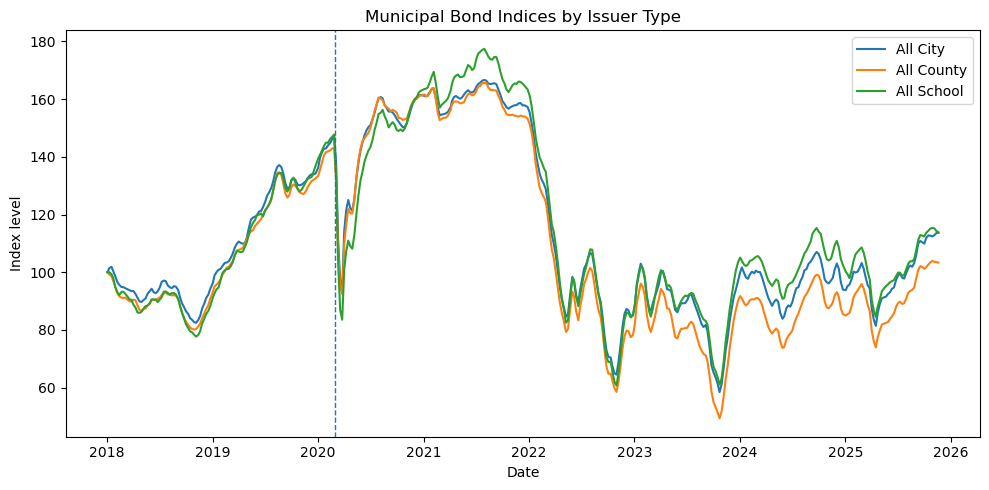

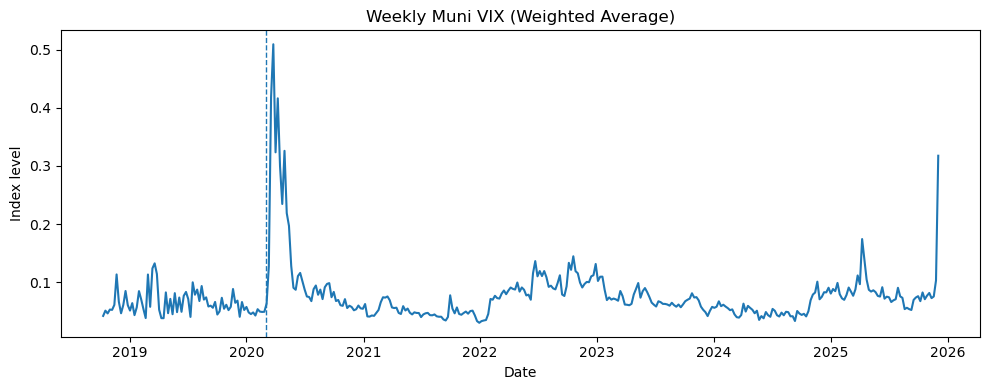

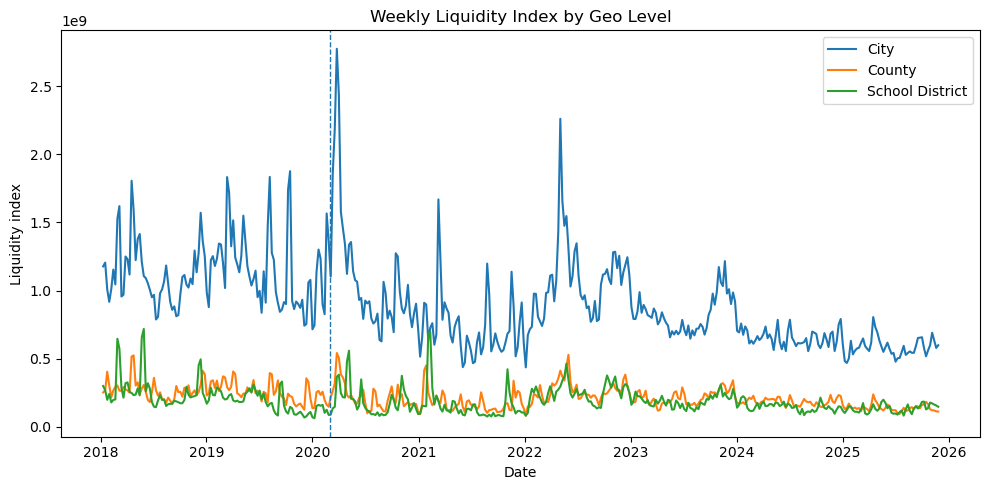

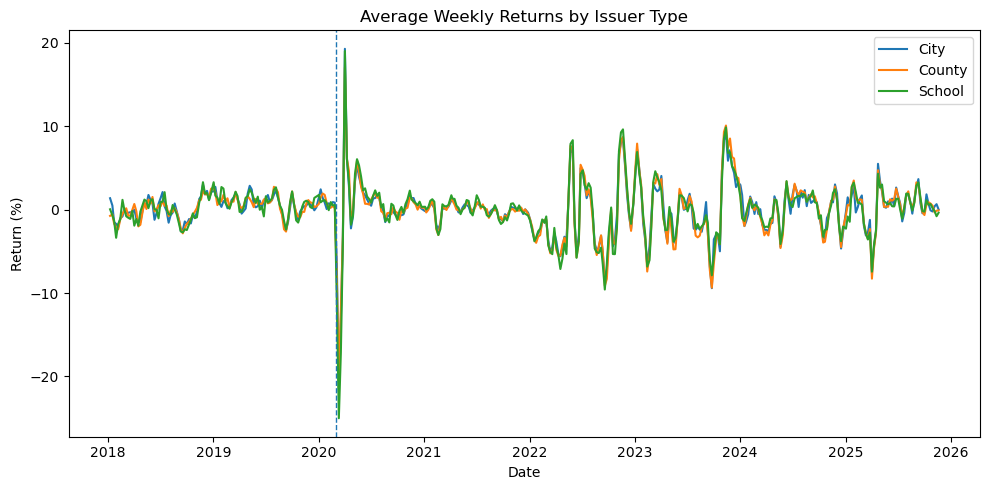

In [23]:
# ==========================================
# DESCRIPTIVE PLOTS FOR PAPER
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

covid_line = pd.Timestamp('2020-03-01')

# ---------- 2. Plot aggregate indices (All City / All County / All School) ----------
plt.figure(figsize=(10,5))
plt.plot(city['date'],   city['All City'],   label='All City')
plt.plot(county['date'], county['All County'], label='All County')
plt.plot(school['date'], school['All School'], label='All School')
plt.axvline(covid_line, linestyle='--', linewidth=1)
plt.title('Municipal Bond Indices by Issuer Type')
plt.ylabel('Index level')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 3. Plot muni VIX ----------
vix_weekly = (
    vix.set_index('date')
       .resample('W-WED')['Weighted Average']
       .mean()
       .to_frame('muni_vix')
)
vix_weekly['muni_vix'] = vix_weekly['muni_vix'].ffill()

plt.figure(figsize=(10,4))
plt.plot(vix_weekly.index, vix_weekly['muni_vix'])
plt.axvline(covid_line, linestyle='--', linewidth=1)
plt.title('Weekly Muni VIX (Weighted Average)')
plt.ylabel('Index level')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# ---------- 4. Plot liquidity indices by geo level ----------
liq_weekly = (
    liq.groupby('geo_level')
       .resample('W-WED', on='date')
       .agg({'rolling_sum': 'mean'})
       .reset_index()
       .rename(columns={'rolling_sum':'liq_index', 'date':'week'})
)

plt.figure(figsize=(10,5))
for lvl, sub in liq_weekly.groupby('geo_level'):
    plt.plot(sub['week'], sub['liq_index'], label=lvl)
plt.axvline(covid_line, linestyle='--', linewidth=1)
plt.title('Weekly Liquidity Index by Geo Level')
plt.ylabel('Liquidity index')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 5. Average weekly returns by issuer type ----------
# Build a simple long panel for aggregate indices only
for df, col, label in [(city, 'All City', 'City'),
                       (county, 'All County', 'County'),
                       (school, 'All School', 'School')]:
    df['ret'] = 100 * np.log(df[col] / df[col].shift(1))
    df['level'] = label

agg_ret = pd.concat([
    city[['date','ret','level']],
    county[['date','ret','level']],
    school[['date','ret','level']]
]).dropna()

avg_ret = (
    agg_ret.groupby(['date','level'])['ret']
           .mean()
           .reset_index()
           .pivot(index='date', columns='level', values='ret')
)

plt.figure(figsize=(10,5))
for col in avg_ret.columns:
    plt.plot(avg_ret.index, avg_ret[col], label=col)
plt.axvline(covid_line, linestyle='--', linewidth=1)
plt.title('Average Weekly Returns by Issuer Type')
plt.ylabel('Return (%)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
# =====================================================
# 1. Scale Liquidity Change for Numerical Stability
# =====================================================

panel_sample2 = panel_sample.copy()
scale = 1e8
panel_sample2['d_liq_scaled'] = panel_sample2['d_liq_index'] / scale

# =====================================================
# 2. Baseline Panel FE Regression (Issuer Fixed Effects)
# =====================================================

baseline_model = smf.ols(
    "ret ~ d_muni_vix + d_liq_scaled + C(issuer)",
    data=panel_sample2
).fit(cov_type='HC1')

print("\n\n===== BASELINE FE REGRESSION =====")
print(baseline_model.summary())

# =====================================================
# 3. Build Lags for Dynamic Panel
# =====================================================

lvl_macro = (
    panel_sample2[['geo_level', 'date', 'd_muni_vix', 'd_liq_scaled']]
    .drop_duplicates(['geo_level', 'date'])
    .sort_values(['geo_level', 'date'])
)

# Create lags (1 and 2 weeks)
for L in [1, 2]:
    lvl_macro[f'd_muni_vix_l{L}'] = lvl_macro.groupby('geo_level')['d_muni_vix'].shift(L)
    lvl_macro[f'd_liq_scaled_l{L}'] = lvl_macro.groupby('geo_level')['d_liq_scaled'].shift(L)

# Merge back into the panel
panel_dyn = panel_sample2.merge(
    lvl_macro,
    on=['geo_level', 'date', 'd_muni_vix', 'd_liq_scaled'],
    how='left'
)

# Keep rows with complete lag information
panel_dyn = panel_dyn.dropna(subset=[
    'd_muni_vix_l1', 'd_muni_vix_l2',
    'd_liq_scaled_l1', 'd_liq_scaled_l2'
])

# =====================================================
# 4. Dynamic Panel FE Regression
# =====================================================

dyn_formula = (
    "ret ~ d_muni_vix + d_muni_vix_l1 + d_muni_vix_l2 "
    "+ d_liq_scaled + d_liq_scaled_l1 + d_liq_scaled_l2 "
    "+ C(issuer)"
)

dyn_model = smf.ols(dyn_formula, data=panel_dyn).fit(cov_type='HC1')

print("\n\n===== DYNAMIC PANEL FE REGRESSION =====")
print(dyn_model.summary())




===== BASELINE FE REGRESSION =====
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     11.47
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           2.79e-92
Time:                        01:21:01   Log-Likelihood:                -14724.
No. Observations:                5238   AIC:                         2.956e+04
Df Residuals:                    5182   BIC:                         2.993e+04
Df Model:                          55                                         
Covariance Type:                  HC1                                         
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

City–County DiD sample: (4656, 14)
          date       issuer level       ret  Post  is_city
51  2019-01-02  Albuquerque  City  1.913962     0        1
104 2020-01-08  Albuquerque  City  0.483830     0        1
105 2020-01-15  Albuquerque  City  2.651615     0        1
106 2020-01-22  Albuquerque  City  9.441130     0        1
107 2020-01-29  Albuquerque  City -2.326078     0        1


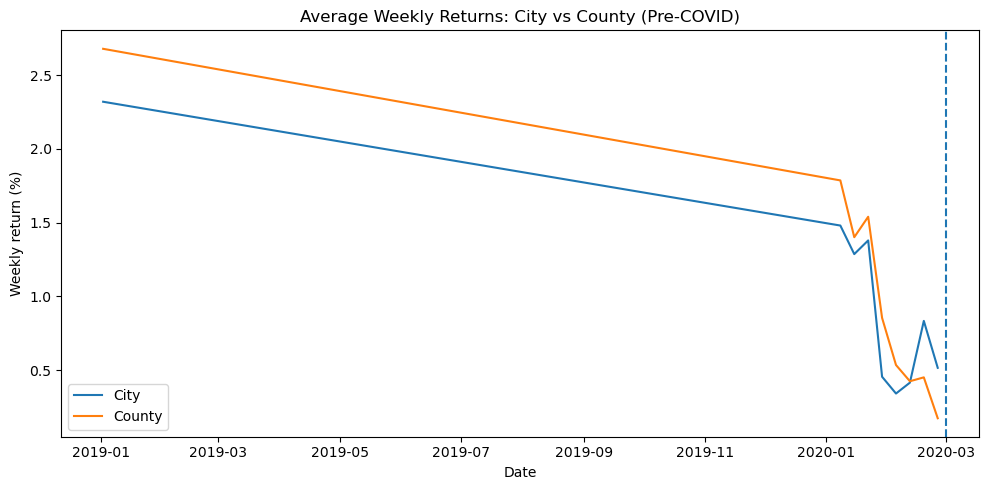

In [11]:
# ==========================================
# CITY–COUNTY DiD: DATA & PARALLEL TRENDS
# ==========================================

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Start from panel_sample (clean FE data with ret, d_muni_vix, d_liq_index, etc.)
did_cc = panel_sample.copy()

# Keep only City and County issuers
did_cc = did_cc[did_cc['level'].isin(['City', 'County'])].copy()

# 1. Define POST dummy (COVID shock onset)
did_cc['Post'] = (did_cc['date'] >= pd.Timestamp('2020-03-01')).astype(int)

# 2. Treatment indicator: City vs County (County is control group)
did_cc['is_city'] = (did_cc['level'] == 'City').astype(int)

# 3. Interaction term for DiD
did_cc['Post_city'] = did_cc['Post'] * did_cc['is_city']

print("City–County DiD sample:", did_cc.shape)
print(did_cc[['date', 'issuer', 'level', 'ret', 'Post', 'is_city']].head())

# ------------------------------------------
# Parallel trends check: City vs County ONLY
# ------------------------------------------

pre_cc = did_cc[did_cc['date'] < pd.Timestamp('2020-03-01')].copy()

avg_pre_cc = (
    pre_cc.groupby(['date', 'level'])['ret']
          .mean()
          .reset_index()
          .pivot(index='date', columns='level', values='ret')
)

plt.figure(figsize=(10, 5))
for col in avg_pre_cc.columns:
    plt.plot(avg_pre_cc.index, avg_pre_cc[col], label=col)

plt.axvline(pd.Timestamp('2020-03-01'), linestyle='--')
plt.title("Average Weekly Returns: City vs County (Pre-COVID)")
plt.ylabel("Weekly return (%)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
# ================================
# 1) Baseline DiD (no controls)
# ================================
# ret_it = α_i + β(Post_t × City_i) + λ Post_t + ε_it

formula_did_base = "ret ~ Post_city + Post + C(issuer)"

model_did_base = smf.ols(
    formula_did_base,
    data=did_cc
).fit(cov_type='cluster', cov_kwds={'groups': did_cc['issuer']})

print("\n======================================")
print(" City–County DiD (Baseline, no controls)")
print("======================================")
print(model_did_base.summary())

# ================================
# 2) DiD with controls
# ================================
# ret_it = α_i + β(Post×City) + λ Post + θ d_muni_vix + φ d_liq_scaled + issuer FE + ε_it

formula_did_ctrl = (
    "ret ~ Post_city + Post + d_muni_vix + d_liq_scaled + C(issuer)"
)

model_did_ctrl = smf.ols(
    formula_did_ctrl,
    data=did_cc
).fit(cov_type='cluster', cov_kwds={'groups': did_cc['issuer']})

print("\n======================================")
print(" City–County DiD (With controls)")
print("======================================")
print(model_did_ctrl.summary())

# Main DiD coefficient
beta_hat = model_did_ctrl.params['Post_city']
se_beta  = model_did_ctrl.bse['Post_city']
print(f"\nDiD estimate (Post_city): {beta_hat:.4f} (clustered SE = {se_beta:.4f})")



 City–County DiD (Baseline, no controls)
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                     53.62
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           7.43e-13
Time:                        00:19:25   Log-Likelihood:                -13635.
No. Observations:                4656   AIC:                         2.737e+04
Df Residuals:                    4606   BIC:                         2.769e+04
Df Model:                          49                                         
Covariance Type:              cluster                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

C:\Users\chait\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 49, but rank is 2
  warnings.warn('covariance of constraints does not have full '
C:\Users\chait\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 51, but rank is 4
  warnings.warn('covariance of constraints does not have full '


In [17]:
simple_did = smf.ols(
    "ret ~ Post_city + Post + is_city",
    data=did_cc
).fit(cov_type='cluster', cov_kwds={'groups': did_cc['issuer']})

print(simple_did.summary())


                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     25.16
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           7.41e-10
Time:                        00:22:30   Log-Likelihood:                -13637.
No. Observations:                4656   AIC:                         2.728e+04
Df Residuals:                    4652   BIC:                         2.731e+04
Df Model:                           3                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0938      0.136      8.046      0.0

In [19]:
# ==========================================
# VAR DATA PREP: City / County / School
# ==========================================

import pandas as pd
import numpy as np

# ---------- 1. Load data ----------
city   = pd.read_csv('city_bond_index.csv')
county = pd.read_csv('county_bond_index.csv')
school = pd.read_csv('school_bond_index.csv')
vix    = pd.read_csv('muni_vix_data.csv')
liq    = pd.read_csv('muni_liquidity.csv')

# ---------- 2. Parse dates ----------
city['date']   = pd.to_datetime(city['date'],   format='%d-%m-%Y')
county['date'] = pd.to_datetime(county['date'], format='%Y-%m-%d')
school['date'] = pd.to_datetime(school['date'], format='%Y-%m-%d')
vix['date']    = pd.to_datetime(vix['date'],    format='%Y-%m-%d')
liq['date']    = pd.to_datetime(liq['date'],    format='%Y-%m-%d')

city   = city.sort_values('date')
county = county.sort_values('date')
school = school.sort_values('date')
vix    = vix.sort_values('date')
liq    = liq.sort_values('date')

# ---------- 3. Compute log returns for aggregate indices ----------
# These are the series All City / All County / All School
city['ret']   = 100 * np.log(city['All City']   / city['All City'].shift(1))
county['ret'] = 100 * np.log(county['All County'] / county['All County'].shift(1))
school['ret'] = 100 * np.log(school['All School'] / school['All School'].shift(1))

# ---------- 4. Weekly muni VIX ----------
vix_weekly = (
    vix.set_index('date')
       .resample('W-WED')['Weighted Average']
       .mean()
       .to_frame('muni_vix')
)

vix_weekly['muni_vix'] = vix_weekly['muni_vix'].ffill()
vix_weekly['d_muni_vix'] = vix_weekly['muni_vix'].diff()

# ---------- 5. Weekly liquidity by geo level ----------
liq_weekly = (
    liq.groupby('geo_level')
       .resample('W-WED', on='date')
       .agg({'rolling_sum': 'mean'})
       .reset_index()
       .rename(columns={'rolling_sum': 'liq_index', 'date': 'week'})
)

liq_weekly = liq_weekly.sort_values(['geo_level', 'week'])
liq_weekly['d_liq_index'] = liq_weekly.groupby('geo_level')['liq_index'].diff()
liq_weekly['d_liq_scaled'] = liq_weekly['d_liq_index'] / 1e8  # rescale for numerics

# mapping between our index types and liquidity geo_levels
geo_map = {'City': 'City', 'County': 'County', 'School': 'School District'}

# ---------- 6. Helper: build VAR dataframe for a given level ----------
def build_var_df(wide_df, level_name):
    """
    wide_df: city/county/school wide dataframe (with 'date' and 'ret')
    level_name: 'City', 'County', or 'School'
    Returns a dataframe with index 'date' and columns:
        ['d_muni_vix', 'd_liq_scaled', 'ret']
    ordered so orthogonalized IRFs treat:
        1st shock = volatility, 2nd = liquidity, 3rd = returns
    """
    df = wide_df[['date', 'ret']].copy()
    df = df.merge(
        vix_weekly.reset_index().rename(columns={'date': 'week'}),
        left_on='date', right_on='week', how='left'
    )
    df = df.merge(
        liq_weekly[liq_weekly['geo_level'] == geo_map[level_name]][['week', 'd_liq_scaled']],
        on='week', how='left'
    )
    # keep only rows where all three series are present
    df = df.dropna(subset=['ret', 'd_muni_vix', 'd_liq_scaled']).copy()
    df = df.set_index('date')

    # order columns for VAR identification: [vol, liq, returns]
    df = df[['d_muni_vix', 'd_liq_scaled', 'ret']]
    return df

# ---------- 7. Build VAR datasets ----------
var_city   = build_var_df(city,   'City')
var_county = build_var_df(county, 'County')
var_school = build_var_df(school, 'School')

print("VAR City shape:",   var_city.shape)
print("VAR County shape:", var_county.shape)
print("VAR School shape:", var_school.shape)

# Quick peek
var_city.head()


VAR City shape: (97, 3)
VAR County shape: (97, 3)
VAR School shape: (97, 3)


,d_muni_vix,d_liq_scaled,ret
date,,,
2019-01-02,-0.009313,-2.674628,2.190052
2020-01-08,-0.009422,0.292422,2.438433
2020-01-15,-0.002846,3.896660,1.405737
2020-01-22,0.002818,1.664626,0.848646
2020-01-29,-0.005291,-0.655428,0.068394



 VAR for All City

Lag order selection:
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -2.593      -2.511     0.07481      -2.560
1      -3.389      -3.062     0.03374      -3.257
2      -3.806      -3.234     0.02227      -3.575
3      -4.081      -3.264     0.01693      -3.751
4     -4.401*     -3.339*    0.01233*     -3.973*
-------------------------------------------------

Chosen lag (AIC): 4
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Dec, 2025
Time:                     00:28:11
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -3.33933
Nobs:                     93.0000    HQIC:                  -3.97256
Log likelihood:          -152.219    FPE:                  0.0123283
AIC:                     -4.40138    

C:\Users\chait\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

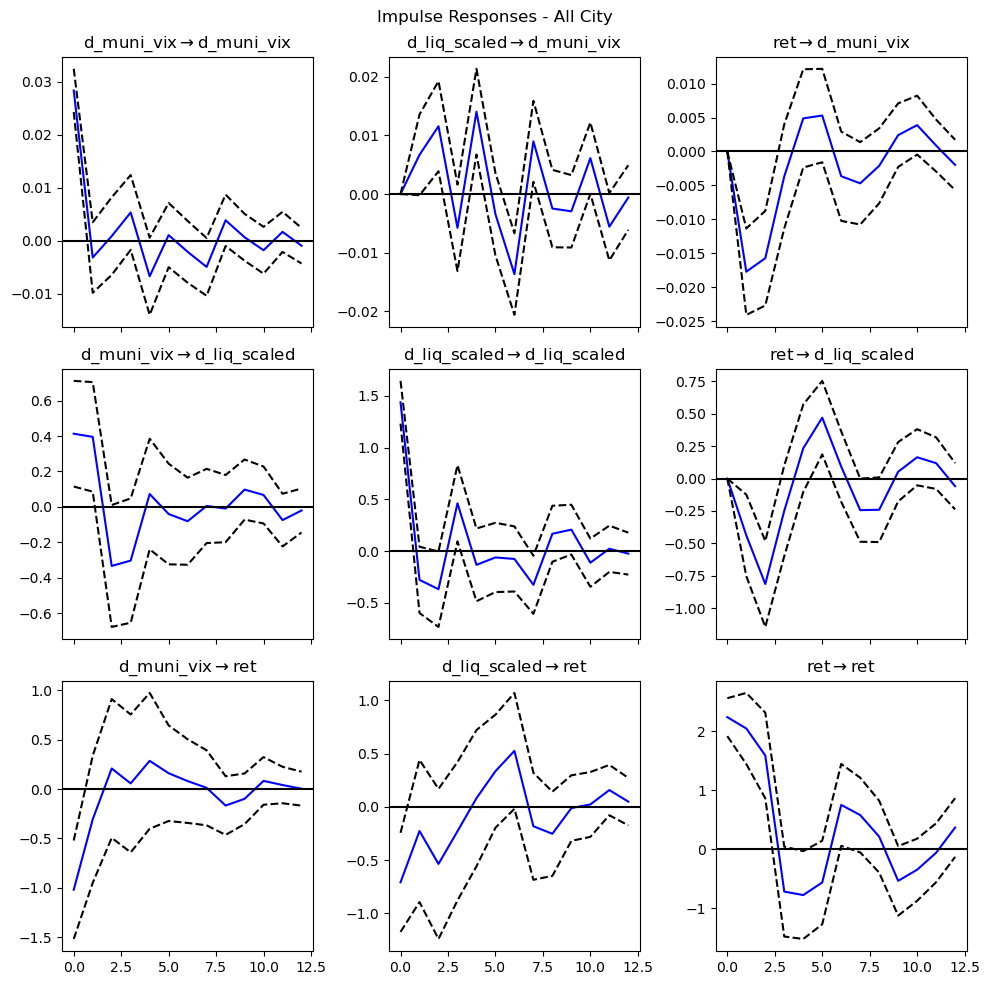

<Figure size 640x480 with 0 Axes>

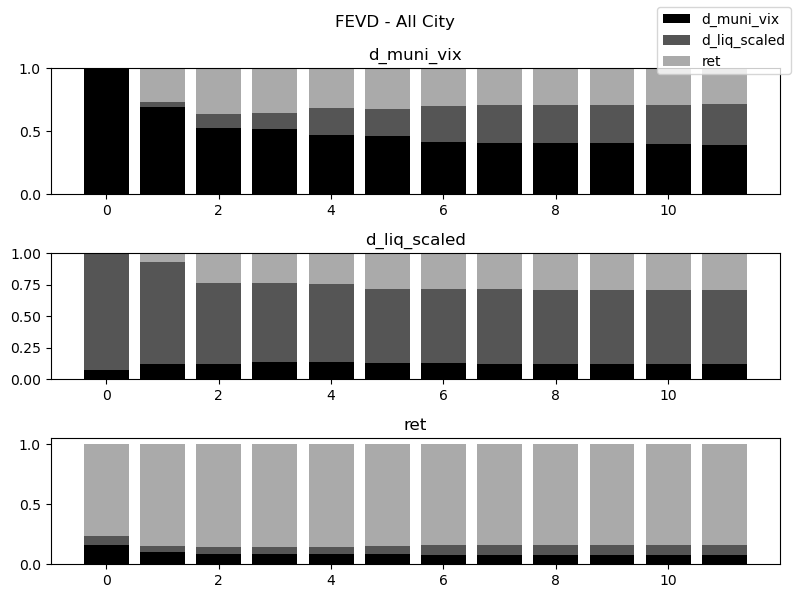


 VAR for All County

Lag order selection:
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -5.340      -5.259    0.004794      -5.307
1      -6.144      -5.817    0.002147      -6.012
2      -6.568     -5.996*    0.001406      -6.337
3      -6.651      -5.834    0.001296      -6.321
4     -6.789*      -5.727   0.001132*     -6.361*
-------------------------------------------------

Chosen lag (AIC): 4
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Dec, 2025
Time:                     00:28:13
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -5.72733
Nobs:                     93.0000    HQIC:                  -6.36056
Log likelihood:          -41.1772    FPE:                 0.00113189
AIC:                     -6.78939  

C:\Users\chait\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

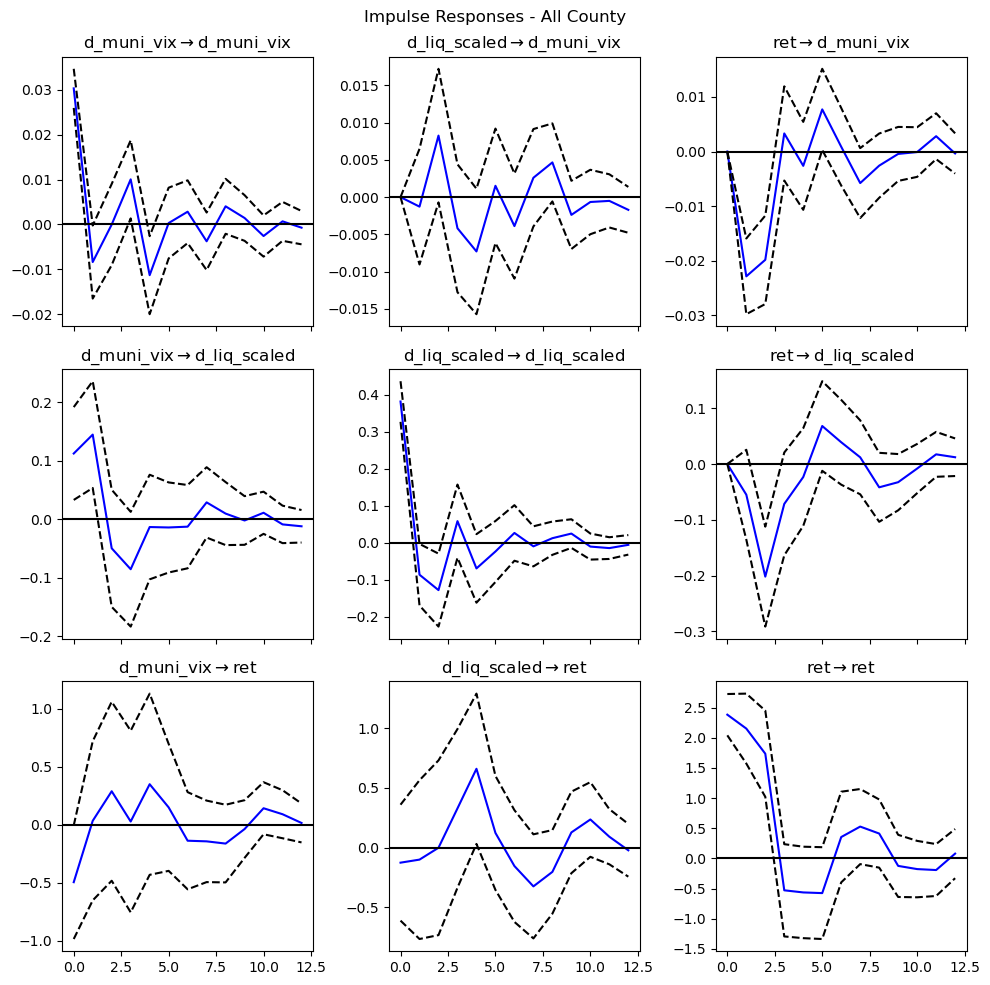

<Figure size 640x480 with 0 Axes>

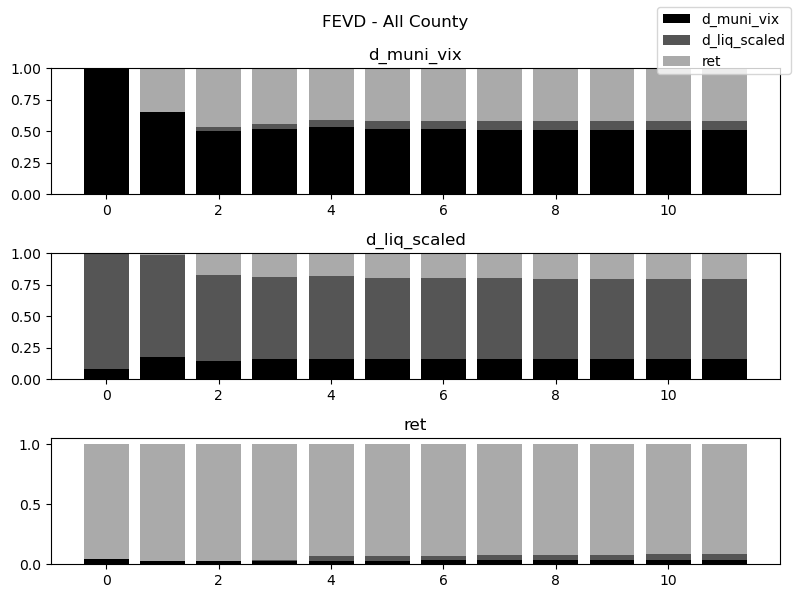


 VAR for All School

Lag order selection:
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -4.332      -4.251     0.01314      -4.299
1      -5.163      -4.836    0.005725      -5.031
2      -5.682     -5.111*    0.003408      -5.452
3      -5.870      -5.053    0.002830     -5.540*
4     -5.904*      -4.842   0.002744*      -5.475
-------------------------------------------------

Chosen lag (AIC): 4
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Dec, 2025
Time:                     00:28:14
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -4.84181
Nobs:                     93.0000    HQIC:                  -5.47504
Log likelihood:          -82.3542    FPE:                 0.00274401
AIC:                     -5.90386  

C:\Users\chait\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<Figure size 640x480 with 0 Axes>

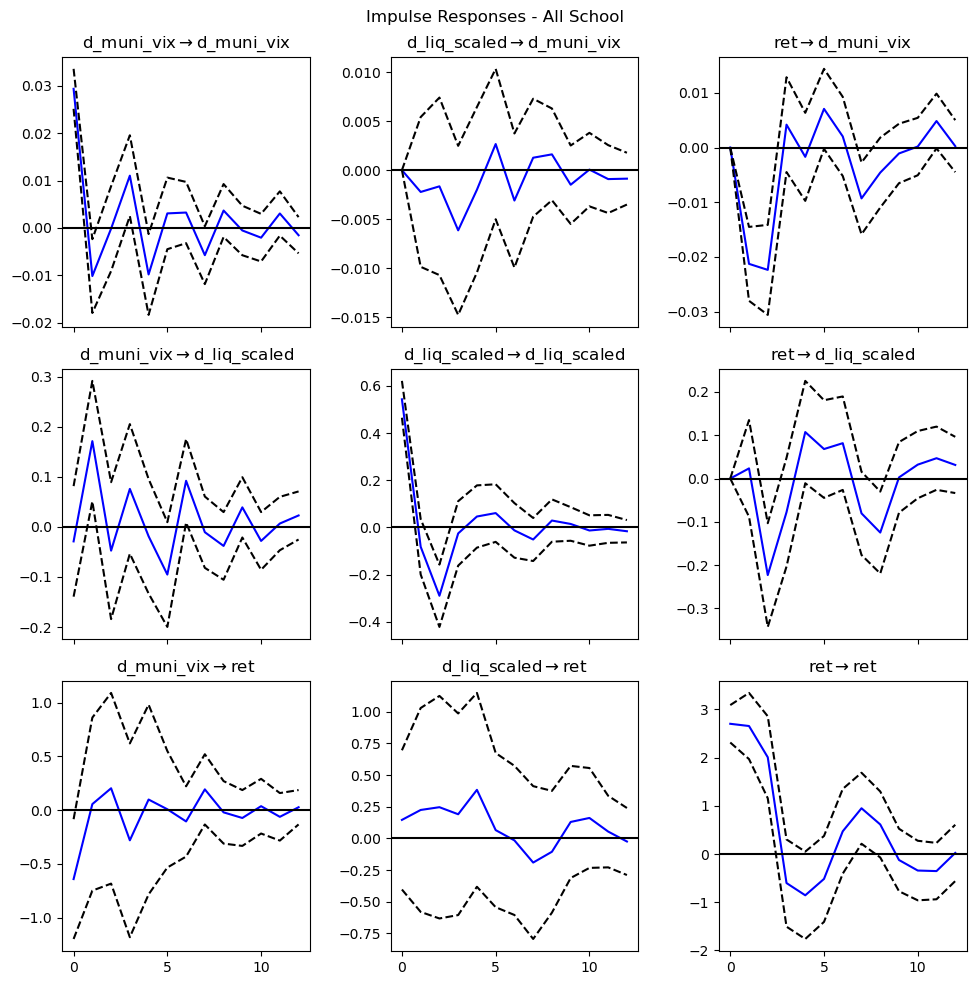

<Figure size 640x480 with 0 Axes>

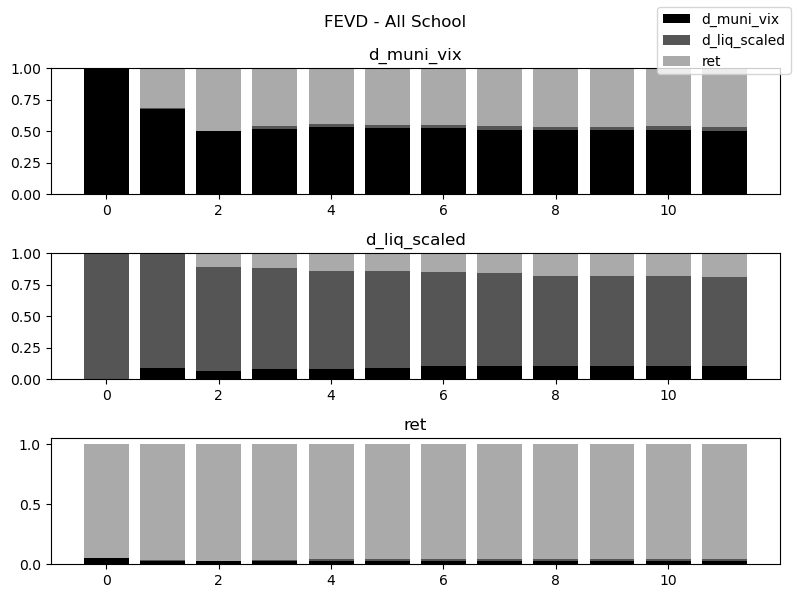

In [21]:
# ==========================================
# VAR ESTIMATION + IRFs + FEVD
# ==========================================

import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

def estimate_var_and_irf(df, name, maxlags=4, irf_horizon=12):
    """
    df: dataframe with columns ['d_muni_vix','d_liq_scaled','ret']
    name: label for printing and plot titles
    maxlags: maximum lag length to consider
    irf_horizon: horizon (in weeks) for IRFs and FEVD
    """
    print(f"\n==============================")
    print(f" VAR for {name}")
    print(f"==============================")

    # 1. Lag selection
    model = VAR(df)
    sel = model.select_order(maxlags=maxlags)
    print("\nLag order selection:")
    print(sel.summary())

    # Choose lag with minimum AIC (fallback to 2 if something weird)
    chosen_lag = sel.selected_orders.get('aic', 2)
    print(f"\nChosen lag (AIC): {chosen_lag}")

    # 2. Estimate VAR
    res = model.fit(chosen_lag)
    print(res.summary())

    # 3. Impulse Response Functions (orthogonalized via Cholesky)
    # Ordering: [d_muni_vix, d_liq_scaled, ret]
    irf = res.irf(irf_horizon)

    # Plot IRFs for return only (easier for paper)
    plt.figure()
    irf.plot(orth=True)
    plt.suptitle(f"Impulse Responses - {name}")
    plt.tight_layout()
    plt.show()

    # 4. Forecast Error Variance Decomposition (FEVD) for returns
    fevd = res.fevd(irf_horizon)
    plt.figure()
    fevd.plot(figsize=(8, 6))
    plt.suptitle(f"FEVD - {name}")
    plt.tight_layout()
    plt.show()

    return res, irf, fevd


# ---------- Run VARs for each issuer type ----------

res_city, irf_city, fevd_city = estimate_var_and_irf(var_city,   "All City",   maxlags=4, irf_horizon=12)
res_county, irf_county, fevd_county = estimate_var_and_irf(var_county, "All County", maxlags=4, irf_horizon=12)
res_school, irf_school, fevd_school = estimate_var_and_irf(var_school, "All School", maxlags=4, irf_horizon=12)


VAR City shape: (97, 3)
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Dec, 2025
Time:                     01:22:14
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -3.33933
Nobs:                     93.0000    HQIC:                  -3.97256
Log likelihood:          -152.219    FPE:                  0.0123283
AIC:                     -4.40138    Det(Omega_mle):      0.00832597
--------------------------------------------------------------------
Results for equation d_muni_vix
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.002516         0.003106            0.810           0.418
L1.d_muni_vix          -0.405839         0.104595           -3.880           0.000
L1.d_liq_scaled        

C:\Users\chait\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


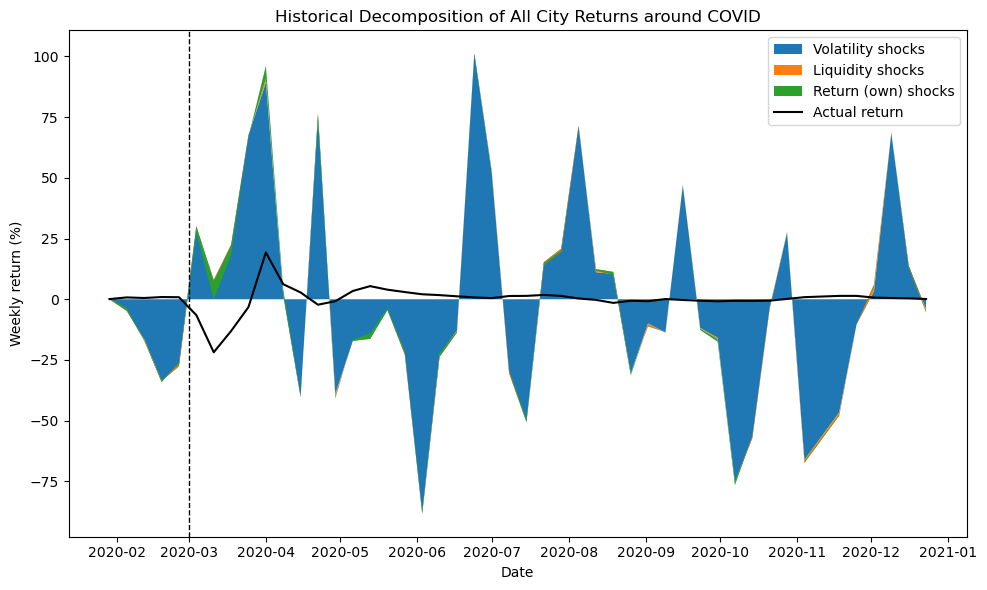

In [27]:
# ==========================================
# HISTORICAL DECOMPOSITION AROUND COVID
# (All City VAR: vol, liq, returns)
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# ---------- 1. Rebuild var_city (same as in VAR section) ----------
# Re-use city, vix, liq loaded above; if not, reload as in Block 1.

geo_map = {'City': 'City', 'County': 'County', 'School': 'School District'}

# weekly vix
vix_weekly = (
    vix.set_index('date')
       .resample('W-WED')['Weighted Average']
       .mean()
       .to_frame('muni_vix')
)
vix_weekly['muni_vix'] = vix_weekly['muni_vix'].ffill()
vix_weekly['d_muni_vix'] = vix_weekly['muni_vix'].diff()

# weekly liquidity
liq_weekly = (
    liq.groupby('geo_level')
       .resample('W-WED', on='date')
       .agg({'rolling_sum':'mean'})
       .reset_index()
       .rename(columns={'rolling_sum':'liq_index', 'date':'week'})
)
liq_weekly = liq_weekly.sort_values(['geo_level','week'])
liq_weekly['d_liq_index'] = liq_weekly.groupby('geo_level')['liq_index'].diff()
liq_weekly['d_liq_scaled'] = liq_weekly['d_liq_index']/1e8

def build_var_df(wide_df, level_name):
    df = wide_df[['date', 'ret']].copy()
    df = df.merge(
        vix_weekly.reset_index().rename(columns={'date':'week'}),
        left_on='date', right_on='week', how='left'
    )
    df = df.merge(
        liq_weekly[liq_weekly['geo_level']==geo_map[level_name]][['week','d_liq_scaled']],
        on='week', how='left'
    )
    df = df.dropna(subset=['ret','d_muni_vix','d_liq_scaled']).copy()
    df = df.set_index('date')
    # order: [vol, liq, ret]
    return df[['d_muni_vix','d_liq_scaled','ret']]

# make sure city has return column (if not already from Block 1)
if 'ret' not in city.columns:
    city['ret'] = 100 * np.log(city['All City'] / city['All City'].shift(1))

var_city = build_var_df(city, 'City')

print("VAR City shape:", var_city.shape)

# ---------- 2. Fit VAR ----------
maxlags = 4
model_city = VAR(var_city)
res_city = model_city.fit(maxlags)   # you can also use model_city.fit(ic='aic')

print(res_city.summary())

# ---------- 3. Historical decomposition of 'ret' ----------
A = res_city.coefs          # shape (p, K, K)
p = res_city.k_ar
K = res_city.neqs
Sigma_u = res_city.sigma_u  # innovation covariance
u = res_city.resid.values   # reduced-form residuals (T_eff x K)
dates_resid = res_city.resid.index
T_eff = u.shape[0]

# Cholesky for structural shocks: u_t = P e_t
P = np.linalg.cholesky(Sigma_u)
e = np.linalg.solve(P, u.T).T        # structural shocks e_t (T_eff x K)

# Compute MA coefficients C_h up to horizon H
def compute_C(A, H):
    p, K, _ = A.shape
    C = [np.eye(K)]
    for h in range(1, H+1):
        C_h = np.zeros((K, K))
        for L in range(1, min(p, h)+1):
            C_h += A[L-1] @ C[h-L]
        C.append(C_h)
    return C

H = 12   # number of past lags of shocks to attribute
C_list = compute_C(A, H)

# Contributions of each shock type to 'ret'
var_names = var_city.columns.tolist()  # ['d_muni_vix','d_liq_scaled','ret']
k_ret = var_names.index('ret')

contrib = np.zeros((T_eff, K))   # columns: vol_shock, liq_shock, ret_shock

for t in range(T_eff):
    # sum over past shocks up to H or up to t
    max_j = min(H, t)
    for j in range(max_j + 1):
        Cj = C_list[j]
        for k in range(K):
            contrib[t, k] += Cj[k_ret, k] * e[t - j, k]

contrib_df = pd.DataFrame(contrib, index=dates_resid,
                          columns=['vol_shock','liq_shock','ret_shock'])

# Actual returns aligned with residuals (VAR drops first p obs)
ret_aligned = var_city['ret'].iloc[p:]
contrib_df['actual_ret'] = ret_aligned.values
contrib_df['approx_ret'] = contrib_df[['vol_shock','liq_shock','ret_shock']].sum(axis=1)
contrib_df['residual'] = contrib_df['actual_ret'] - contrib_df['approx_ret']

print(contrib_df.head())

# ---------- 4. Plot historical decomposition around COVID ----------
window = contrib_df.loc['2019-01-01':'2020-12-31']

plt.figure(figsize=(10,6))
plt.stackplot(window.index,
              window['vol_shock'],
              window['liq_shock'],
              window['ret_shock'],
              labels=['Volatility shocks','Liquidity shocks','Return (own) shocks'])
plt.plot(window.index, window['actual_ret'], color='black', linewidth=1.5, label='Actual return')
plt.axvline(pd.Timestamp('2020-03-01'), linestyle='--', color='k', linewidth=1)
plt.title('Historical Decomposition of All City Returns around COVID')
plt.ylabel('Weekly return (%)')
plt.xlabel('Date')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [29]:
# ==========================================
# BVAR DATA PREP (All City)
# ==========================================

import pandas as pd
import numpy as np

# ---------- 1. Load data ----------
city   = pd.read_csv('city_bond_index.csv')
county = pd.read_csv('county_bond_index.csv')
school = pd.read_csv('school_bond_index.csv')
vix    = pd.read_csv('muni_vix_data.csv')
liq    = pd.read_csv('muni_liquidity.csv')

# ---------- 2. Parse dates ----------
city['date']   = pd.to_datetime(city['date'],   format='%d-%m-%Y')
county['date'] = pd.to_datetime(county['date'], format='%Y-%m-%d')
school['date'] = pd.to_datetime(school['date'], format='%Y-%m-%d')
vix['date']    = pd.to_datetime(vix['date'],    format='%Y-%m-%d')
liq['date']    = pd.to_datetime(liq['date'],    format='%Y-%m-%d')

city   = city.sort_values('date')
county = county.sort_values('date')
school = school.sort_values('date')
vix    = vix.sort_values('date')
liq    = liq.sort_values('date')

# ---------- 3. Log returns for indices ----------
city['ret']   = 100 * np.log(city['All City']   / city['All City'].shift(1))
county['ret'] = 100 * np.log(county['All County'] / county['All County'].shift(1))
school['ret'] = 100 * np.log(school['All School'] / school['All School'].shift(1))

# ---------- 4. Weekly muni VIX ----------
vix_weekly = (
    vix.set_index('date')
       .resample('W-WED')['Weighted Average']
       .mean()
       .to_frame('muni_vix')
)
vix_weekly['muni_vix'] = vix_weekly['muni_vix'].ffill()
vix_weekly['d_muni_vix'] = vix_weekly['muni_vix'].diff()

# ---------- 5. Weekly liquidity by geo level ----------
liq_weekly = (
    liq.groupby('geo_level')
       .resample('W-WED', on='date')
       .agg({'rolling_sum': 'mean'})
       .reset_index()
       .rename(columns={'rolling_sum': 'liq_index', 'date': 'week'})
)
liq_weekly = liq_weekly.sort_values(['geo_level', 'week'])
liq_weekly['d_liq_index'] = liq_weekly.groupby('geo_level')['liq_index'].diff()
liq_weekly['d_liq_scaled'] = liq_weekly['d_liq_index'] / 1e8  # rescale for numerics

geo_map = {'City': 'City', 'County': 'County', 'School': 'School District'}

def build_var_df(wide_df, level_name):
    df = wide_df[['date', 'ret']].copy()
    df = df.merge(
        vix_weekly.reset_index().rename(columns={'date': 'week'}),
        left_on='date', right_on='week', how='left'
    )
    df = df.merge(
        liq_weekly[liq_weekly['geo_level'] == geo_map[level_name]][['week', 'd_liq_scaled']],
        on='week', how='left'
    )
    df = df.dropna(subset=['ret', 'd_muni_vix', 'd_liq_scaled']).copy()
    df = df.set_index('date')
    df = df[['d_muni_vix', 'd_liq_scaled', 'ret']]
    return df

# VAR-style dataset for All City
var_city = build_var_df(city, 'City')

# ---------- 6. Standardize for BVAR ----------
# Standardizing makes the prior simpler (shrinkage toward 0 on same scale)
df_bvar_city = (var_city - var_city.mean()) / var_city.std()

print(df_bvar_city.head())
print("Shape:", df_bvar_city.shape)


            d_muni_vix  d_liq_scaled       ret
date                                          
2019-01-02   -0.202694     -1.286933  0.467113
2020-01-08   -0.205065      0.144805  0.531127
2020-01-15   -0.061718      1.884016  0.264975
2020-01-22    0.061741      0.806956  0.121399
2020-01-29   -0.115014     -0.312576 -0.079691
Shape: (97, 3)


Y shape: (95, 3)
X shape: (95, 7)

Posterior mean of Sigma (innovation covariance):
[[ 0.5821123   0.06619755 -0.25695759]
 [ 0.06619755  0.55948269 -0.17713496]
 [-0.25695759 -0.17713496  0.56640178]]

Posterior mean A matrices (All City, standardized variables):
A1 =
[[-0.56344673  0.04974965 -0.6484441 ]
 [ 0.25262684 -0.15238111 -0.28395043]
 [ 0.28397921  0.20613263  0.78601709]]

A2 =
[[-0.38654979  0.1576146  -0.28291007]
 [-0.09966651 -0.43983389 -0.24260431]
 [ 0.27152679 -0.03699507 -0.03550894]]


IRFs array shape: (13, 3, 3)
Variable ordering: ['d_muni_vix', 'd_liq_scaled', 'ret']


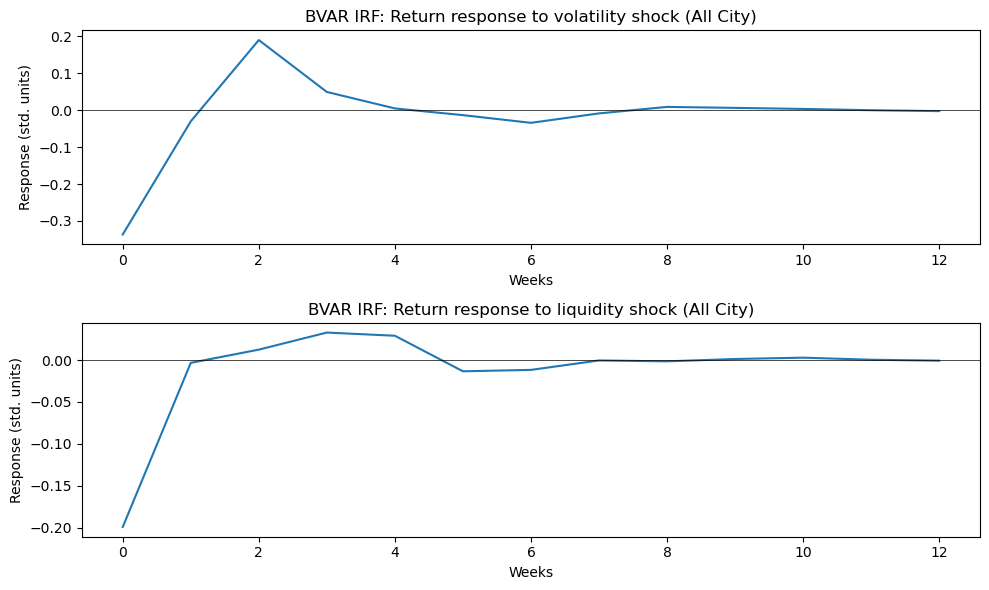

In [31]:
# ==========================================
# CLOSED-FORM BVAR (Normal–Inverse-Wishart)
# ==========================================

import numpy as np
import matplotlib.pyplot as plt

# df_bvar_city from Block 1
Y_df = df_bvar_city.copy()
p = 2   # VAR lag order; 2 is reasonable given sample size
K = Y_df.shape[1]
T = Y_df.shape[0]

# ---------- 1. Build Y and X matrices for VAR(p) ----------
# Y_t = B' X_t + u_t
# Y: (T-p) x K
# X: (T-p) x (1 + K*p)  [intercept + lagged values]

Y = Y_df.values[p:, :]           # from time p onward
X_rows = []

for t in range(p, T):
    lags = []
    for L in range(1, p + 1):
        lags.append(Y_df.values[t - L, :])
    X_t = np.concatenate(([1.0], np.concatenate(lags)))   # 1 + K*p
    X_rows.append(X_t)

X = np.vstack(X_rows)            # (T-p) x (1+Kp)
n_obs = Y.shape[0]
n_params = X.shape[1]            # 1 + K*p

print("Y shape:", Y.shape)
print("X shape:", X.shape)

# ---------- 2. Conjugate prior: B|Sigma ~ MN(B0, Sigma, Omega0), Sigma ~ IW(S0, nu0) ----------
# Simple shrinkage prior: B0 = 0, Omega0 = tau^2 * I, S0 = I, nu0 = K + 2

tau = 0.5               # overall shrinkage: smaller = stronger shrink toward 0
B0 = np.zeros((n_params, K))
Omega0 = (tau ** 2) * np.eye(n_params)     # prior covariance over regressors
nu0 = K + 2
S0 = np.eye(K)

Omega0_inv = np.linalg.inv(Omega0)

# ---------- 3. Posterior updates ----------
# Omega_n = (Omega0^(-1) + X'X)^(-1)
# B_n = Omega_n (Omega0^(-1) B0 + X'Y)
# nu_n = nu0 + n_obs
# S_n = S0 + Y'Y + B0' Omega0^(-1) B0 - B_n' (Omega0^(-1) + X'X) B_n

XTX = X.T @ X                           # (n_params x n_params)
XTY = X.T @ Y                           # (n_params x K)

Omega_n = np.linalg.inv(Omega0_inv + XTX)
B_n = Omega_n @ (Omega0_inv @ B0 + XTY)   # posterior mean of B

nu_n = nu0 + n_obs

YTY = Y.T @ Y
term_B0 = B0.T @ Omega0_inv @ B0
Omega_n_inv = Omega0_inv + XTX
term_Bn = B_n.T @ Omega_n_inv @ B_n

S_n = S0 + YTY + term_B0 - term_Bn

# Posterior mean of Sigma (innovation covariance)
Sigma_post_mean = S_n / (nu_n - K - 1)

print("\nPosterior mean of Sigma (innovation covariance):")
print(Sigma_post_mean)

# ---------- 4. Extract A1, A2 matrices from B_n ----------
# B_n shape: (1 + K*p) x K
# Rows:
#   0             : intercepts
#   1..K          : lag 1 coefficients
#   K+1..2K       : lag 2 coefficients
# etc.

intercept = B_n[0, :]                   # not used for IRFs
A_mats = []                             # list [A1, A2, ..., Ap], each (K x K)

for lag in range(p):
    row_start = 1 + lag * K
    row_end = 1 + (lag + 1) * K
    block = B_n[row_start:row_end, :]   # (K x K), regressors (rows) × equations (cols)
    A_lag = block.T                     # transpose so A_lag[j,k] = effect of variable k on eq j
    A_mats.append(A_lag)

print("\nPosterior mean A matrices (All City, standardized variables):")
for i, A in enumerate(A_mats, start=1):
    print(f"A{i} =\n{A}\n")

# ---------- 5. Compute orthogonalized IRFs from posterior mean ----------
def compute_bvar_irfs(A_list, Sigma_u, horizon):
    """
    A_list: list of KxK coefficient matrices [A1, ..., Ap]
    Sigma_u: KxK covariance matrix of innovations
    horizon: max horizon H (we compute IRFs for h = 0..H)
    Returns: irfs array of shape (H+1, K, K)
             irfs[h, :, :] = response of each variable (rows) to each shock (columns)
    """
    p = len(A_list)
    K = A_list[0].shape[0]
    irfs = np.zeros((horizon + 1, K, K))

    # Orthogonalization via Cholesky: u_t = P e_t, e_t orthonormal
    P = np.linalg.cholesky(Sigma_u)

    # h = 0: impact response is just P
    irfs[0] = P

    # Store past C_h matrices for recursion; C_h is IRF at horizon h
    C_list = [P]  # C_0

    for h in range(1, horizon + 1):
        C_h = np.zeros((K, K))
        # C_h = A1 C_{h-1} + ... + Ap C_{h-p}
        for L in range(1, min(p, h) + 1):
            C_h += A_list[L - 1] @ C_list[h - L]
        irfs[h] = C_h
        C_list.append(C_h)

    return irfs

H = 12  # horizons (0..12 weeks)
irfs_city_bvar = compute_bvar_irfs(A_mats, Sigma_post_mean, H)

print("\nIRFs array shape:", irfs_city_bvar.shape)

# ---------- 6. Plot IRFs for returns (row index of 'ret') ----------
var_names = Y_df.columns.tolist()
print("Variable ordering:", var_names)
k_ret = var_names.index('ret')  # which row is 'ret'

horizons = np.arange(H + 1)

plt.figure(figsize=(10, 6))

# response of ret to volatility shock (col 0)
plt.subplot(2, 1, 1)
plt.plot(horizons, irfs_city_bvar[:, k_ret, 0])
plt.axhline(0, color='black', linewidth=0.5)
plt.title("BVAR IRF: Return response to volatility shock (All City)")
plt.xlabel("Weeks")
plt.ylabel("Response (std. units)")

# response of ret to liquidity shock (col 1)
plt.subplot(2, 1, 2)
plt.plot(horizons, irfs_city_bvar[:, k_ret, 1])
plt.axhline(0, color='black', linewidth=0.5)
plt.title("BVAR IRF: Return response to liquidity shock (All City)")
plt.xlabel("Weeks")
plt.ylabel("Response (std. units)")

plt.tight_layout()
plt.show()
